In [1]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats
from scipy.spatial import distance
import io
import time#for recording time 
import sys #for getting size of object
!pip install texttable
from texttable import Texttable

plt.rcParams["figure.figsize"] = (10,10)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
random.seed(15)

### *Importing files from github for google colab


In [3]:
url = 'https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/contact_rules.csv'
rules_df  = pd.read_csv(url,header=None,engine='python')
url2='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/frequency_contact.csv'
frequency_df= pd.read_csv(url2,header=None,engine='python')
url3='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/varicella_prevalance.csv'
V_prevalence_df =pd.read_csv(url3,header=None,engine='python')
url4='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/population.csv'
population_df=pd.read_csv(url4,header=None,engine='python')

### *importing files from pc


# THE GRAPH CONTROL PANEL

In [4]:
N =10000# Number of nodes
setting='home'#the setting we are evaluating(home,work,school,other)
clustering_factor=500 #multiplies chance of connecting with N_of_N
clustering=True
sampling_ratio=1000 #In how many iterations we calculate metrics


## 1-Defining Nodes

In [5]:
#defining a dictionary of nodes

group_popularity = dict() #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict() #dictionary of nodes
frequency=dict()


for i, row in population_df.iterrows():
    group_popularity[row[0]]=float(row[1])
    
for i, row in V_prevalence_df.iterrows():
    v_prevalence[row[0]]=[float(row[1]),float(row[2])]
    

#importing data for frequency of contact in each setting for comparison
for i, row in frequency_df.iterrows():
    frequency[row[0]]=dict()
    for i in range(1,6):
        frequency[row[0]][i]=float(row[i])
                    
for i in range(N):#deciding nodes ages
    while True:
        r=random.random()
        t=random.choice(list(group_popularity.keys()))
        if r<=group_popularity[t]:
            nodes_dic[i]={'age':t}
            break


for i in range(N):  #deciding nodes seropositivity
    a=v_prevalence[nodes_dic[i]['age']][0]
    b=v_prevalence[nodes_dic[i]['age']][1]
    r=np.random.random()
    t=np.random.normal(a,(a-b)) 
    if r<=t:
        nodes_dic[i]['infection']=1
    else:
        nodes_dic[i]['infection']=0
        

### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [6]:

# the number of nodes in each group:

age_count = {}
for n in nodes_dic.keys():
    
    if nodes_dic[n]['age'] in age_count:
        age_count[nodes_dic[n]['age']] = age_count[nodes_dic[n]['age']] + 1
    else:
        age_count[nodes_dic[n]['age']] = 1
age_count

{'20_24': 860,
 '5_9': 766,
 '55_59': 437,
 '50_54': 464,
 '30_34': 1044,
 '0_4': 872,
 '10_14': 743,
 '25_29': 1027,
 '75+': 258,
 '35_39': 885,
 '40_44': 642,
 '15_19': 715,
 '70_74': 143,
 '65_69': 216,
 '45_49': 594,
 '60_64': 334}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [7]:
#importing rules_data from .csv to nested dictionary
rules_data={}  # rules_data contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]

for i, row in rules_df.iterrows():
    
    location.append(row[0])
    contactor.append(row[1])
    contactee.append(row[2])
    contact_number.append(float(row[3]))

for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules_data[location[o]]=temp_1.copy()     

In [8]:
#transforming rules_data to rules so it will be symetrical

rules=dict()

for i in rules_data.keys():
    rules[i]=dict()
    for j in rules_data[i].keys():
        rules[i][j]=dict() 
        for k in rules_data[i][j].keys():

            total_j_k_contact=(rules_data[i][j][k]*age_count[j])+(rules_data[i][k][j]*age_count[k])
            rules[i][j][k]=(total_j_k_contact/2)/age_count[j]

In [9]:
#claculating how many contact a person has with all age groups in the setting
#calculating how many 'connectons' is required for the contacts with specific frequency
rules_sum=dict()
for i in rules.keys():
    rules_sum[i]=dict()
    for j in rules[i].keys():
        t=0
        rules_sum[i][j]={'contact_total':0,'count1':0,'count2':0,'count3':0}
        for k in rules[i][j]:
            t+=rules[i][j][k]
    
        rules_sum[i][j]['contact_total']=t
        rules_sum[i][j]['count1']=t*frequency[i][1]
        rules_sum[i][j]['count2']=t*frequency[i][2]*(7/1.5)
        rules_sum[i][j]['count3']=t*frequency[i][3]*(30/1.5)
        #number of 'contacts' with random probability
        rules_sum[i][j]['count4']=t*(frequency[i][4]+frequency[i][5])
        rules_sum[i][j]['connection_total']=rules_sum[i][j]['count1']+rules_sum[i][j]['count2']+rules_sum[i][j]['count3']
        
        
#a dictionary of weight/upper_weight ratio for each frequency set       
frequency_grouped={1:1,2:(1.5/7),3:(1.5/30),4:0}

table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['setting','age','contact_total','connection_total','conection 1','conection 2' ,'conection 3','connection 4']])      
print(table.draw())
for i in rules_sum.keys():
    for j in rules_sum[i].keys():
        
        table.add_rows([[i,j,'%f' % rules_sum[i][j]['contact_total'],'%f' % rules_sum[i][j]['connection_total'],'%f' % rules_sum[i][j]['count1'],'%f' % rules_sum[i][j]['count2'],'%f' % rules_sum[i][j]['count3'],'%f' % rules_sum[i][j]['count4']]])
        
        print(table.draw())


setting   age   contact_t   connecti   conectio   conectio   conectio   connecti
                  otal      on_total     n 1        n 2        n 3        on 4  
  all     0_4   10.418651   49.67026   3.975966   12.68824   33.00605   2.073473
                               8                     3          9               
  all     5_9   18.545476   88.41440   7.077325   22.58541   58.75166   3.690837
                               0                     0          5               
  all     10_   21.406692   102.0550   8.169222   26.06991   67.81593   4.260264
          14                   69                    1          5               
  all     15_   18.962588   90.40295   7.236503   23.09338   60.07306   3.773849
          19                   5                     5          6               
  all     20_   11.829069   56.39435   4.514210   14.40590   37.47423   2.354168
          24                   0                     6          4               
  all     25_   11.774562   

## 3-Defining Functions



### 3-1 function run : builds the graph based on rules of connections

In [10]:
#in this block we've defiend a function "Run" 
def Run(nodes_dic,age_count,frequency_grouped):
    
    #building the array based on nodes_dic
    #graph_array=[N * [[connecetions],number of the node,number of connections]
    graph_array=[]
    for i in range(N):
        Age_i=nodes_dic[i]['age']
        Num_connection = np.random.poisson(lam=(rules_sum[setting][Age_i]['contact_total']))
        graph_array.append([[],i,Num_connection])
      
    #making a dictionary that consists of lists of nodes in each age group
    nodes_age_grouped=dict() 
    for i in range(N):     
        if nodes_dic[i]['age'] in nodes_age_grouped:
            nodes_age_grouped[nodes_dic[i]['age']].append(i)    
        else:
            nodes_age_grouped[nodes_dic[i]['age']]=[i]
            
            
    #for storing metrics during run
    samples_T={'p-value wilcoxon': [], 'mean absoloute error': [], 'Manhattan distance': [], 'Euclidean distance': [], 'Chebyshev distance': []}
    
    #building primary graph
    print('building primary graph ...')
    
    #iterating nodes
    for contactor in range(N):
        #checking if they have any place for new connection
        if len(graph_array[contactor][0]) < graph_array[contactor][2]:
            Age_contactor=nodes_dic[contactor]['age']
            not_connected = True #for checking if conection has happend
            
            while not_connected :
                #deciding age of connection
                Age_C=random.choice(list(nodes_age_grouped.keys()))
                r=random.random()
                prob_connection=rules[setting][Age_contactor][Age_C]/(rules_sum[setting][Age_contactor]['contact_total'])
                
                if r <= prob_connection :
                    #deciding a random node from the chosen age group to make connection

                    contactee= random.choice(list(nodes_age_grouped[Age_C]))
                    
                    #checking if contactee has empty capacity
                    
                    if len(graph_array[contactee][0]) < graph_array[contactee][2]:

                        if contactee not in graph_array[contactor][0] and contactee != contactor :

                            not_connected = False

                            graph_array[contactor][0].append(contactee)
                            graph_array[contactee][0].append(contactor)
    #for calculating sampling_ratio               
    sampling_counter=0                                       
    #building complete graph
    print('building complete graph ...')
    for contactor in range(N):
        
        sampling_counter+=1
        
        if sampling_counter == sampling_ratio :
            
            sampling_counter=0
            #calculating metrics for graph at the moment
            samples=sampling(N,graph_array,age_count,rules)
            #storing the metrics
            for metric in samples_T.keys():
                samples_T[metric].append(samples[metric])
            
        Age_contactor=nodes_dic[contactor]['age']
        
        #claculating remaining number of connections to build       
        counter = graph_array[contactor][2]-len(graph_array[contactor][0])
        
        dead_end=False #for checking if there is not enough empty spots to connect this node
        #completing graph 
        while counter > 0 and not dead_end :
            
            #connecting to N_of_N and making triangels
            if clustering :
                
                
                for i in range(clustering_factor):
                    
                    if counter > 0 :
                        #building and updating list of N_of_N
                        N_of_N=list()
                        for j in graph_array[contactor][0]:

                            for k in graph_array[j][0]:

                                N_of_N.append(k)

                        N_of_N=list(set(N_of_N))

                        #iterating in N_of_N to make connections
                        for contactee in N_of_N :

                                Age_C=nodes_dic[contactee]['age']
                                prob_connection=rules[setting][Age_contactor][Age_C]/(rules_sum[setting][Age_contactor]['contact_total']*age_count[Age_C])
                                r=random.random()
                                #checking if contactee has free capacity
                                if len(graph_array[contactee][0]) < graph_array[contactee][2]:
                                    if r <= prob_connection and contactee not in graph_array[contactor][0]:

                                            counter-=1

                                            graph_array[contactor][0].append(contactee)
                                            graph_array[contactee][0].append(contactor) 
            
            #making random connections if N_of_N doesn't have enouhg nodes
            if counter > 0:
                counter_null_iteration=0#counts number of iterations that fail to form connection
                random_connection =False
                while random_connection == False and not dead_end :
                    
                    #deciding age of connection
                    Age_C=random.choice(list(nodes_age_grouped.keys()))
                    r=random.random()
                    prob_connection=rules[setting][Age_contactor][Age_C]/(rules_sum[setting][Age_contactor]['contact_total'])
                    
                    if r <= prob_connection:
                        #deciding a random node from the chosen age group to make connection

                        contactee= random.choice(list(nodes_age_grouped[Age_C]))
                        counter_null_iteration+=1
                        #if we have iterated 1000 times without forming connection the node is in dead end
                        if counter_null_iteration > 1000 :
                            dead_end=True
                            print(contactor,'hit dead end')
                        
                        #checking contactee for capacity of new connections
                        if len(graph_array[contactee][0]) < graph_array[contactee][2]:

                            if contactee not in graph_array[contactor][0] and contactee != contactor :

                                random_connection = True
                                counter-=1

                                graph_array[contactor][0].append(contactee)
                                graph_array[contactee][0].append(contactor)


#putting data from graph to a list of connections
    connections_list=list()
    for i in range(N):
        for j in range(len(graph_array[i][0])):
            k=graph_array[i][0][j]
        
            if i<k:
                connections_list.append((i,k))
            elif k<i:
                connections_list.append((k,i))
    #removing duplicates
    connections_list=list(set(connections_list))
    
                             
    results={'graph_array':graph_array,'nodes_age_grouped':nodes_age_grouped,'connections':connections_list,'samples_T':samples_T}                           
    return(results)


### 3-2 function Run_S imports graph and checks for connections in each day 

In [11]:
#Run_S runs the model and stores conections but do not change the weights
def Run_S (nodes_dic,N_day,rules,age_count,N,results):
    
    nodes_age_grouped=results['nodes_age_grouped']
    graph_array=results['graph_array']
    connections=results['connections']

    #in this list the day that connection has happened is stored
    #contacts=[N*[D0[],D1[]]]
    contacts=[] 
    for i in range(N):
        contacts.append([])
        
            
    for d in range(N_day):
        #adding empty list for day to each node
        for i in range(N):
            contacts[i].append([])
         #checking if contacts happen and storing them   
        
        for j in connections:
            contacts[j[0]][d].append(j[1])
            contacts[j[1]][d].append(j[0])
                    
    return(contacts)


### 3-3 function sampling checks the graph and calculates metrics during the run

In [12]:
#this function claculates metric for graph during the run

def sampling(N,graph_array,age_count,rules):
    #builds list of contacts based on current situation of graph
    contacts=[]
    for node in range(N):
        contacts.append([])
        contacts[node].append(graph_array[node][0])
    #calculates metrics    
    Metr_W = Metric_W(contacts,age_count,rules)
    
    samples={'p-value wilcoxon':'%f' % Metr_W['wilx'][1],'mean absoloute error':Metr_W['M_Abs'],'Manhattan distance':Metr_W['man_dis'],'Euclidean distance':Metr_W['eu_dis'],'Chebyshev distance':Metr_W['cheb_dis']}
     
    return(samples)

### 3-4 function Metric_w calculates metrics for the input graph

In [13]:
#this function returns measures for comparison age stratified number of contacts 


def Metric_W(Run_S,age_count,rules) : 
    

    contacts=Run_S
    
    
    L1=[]
    L2=[]
    L3=[]
    

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0
    
    for i in range(N):
            for j in contacts[i][0]:
                age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
                if i!=j and age_p!=0 : 
                    t= 1/age_count[nodes_dic[i]['age']]
                    rules_m[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]+=t
                         
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            
            L1.append(rules[setting][i][j])
            L2.append(rules_m[setting][i][j])
            if rules[setting][i][j]!=0:
                L3.append(abs((rules_m[setting][i][j])-(rules[setting][i][j]))/rules[setting][i][j])
            else:
                L3.append(0)
                
    wilx=stats.wilcoxon(L1,L2,zero_method='wilcox', correction=False, alternative='two-sided')
    M_Abs=statistics.mean(L3)
    #Manhattan distance
    man_dis=distance.cityblock(L1, L2)
    #Euclidean distance
    eu_dis=distance.euclidean(L1,L2)
    #Chebyshev distance
    cheb_dis=distance.chebyshev(L1,L2)
    #Pearson corelation
    prs_cor=stats.pearsonr(L1,L2)
    
    
    Metric_W ={'wilx':wilx,'M_Abs':M_Abs,'rules_m':rules_m,'L3':L3,'man_dis':man_dis,'eu_dis':eu_dis,'cheb_dis':cheb_dis, 'prs_cor': prs_cor}
    
    return(Metric_W)

### 3-5 function clustering_rate calculate number of triangles and ratio of contacts involved in a triangel compared to total  contacts 

In [14]:
#claculate clustering by counting number of triangels
def clustering_rate (results):
    
    graph_array=results['graph_array']
    t_triangel=0
    t_contact=0
    for node in range(N):
        #building list of neighbor of neighbors
        N_of_N=[]
        for neighbor in graph_array[node][0]:
            for neighbor2 in graph_array[neighbor][0]:
                N_of_N.append(neighbor2)
        #checking for triangels
        
        for neighbor in graph_array[node][0]:
            t_contact+=1
            if neighbor in N_of_N :
                t_triangel += 1
                       
    ratio_triangel=t_triangel/t_contact
                
    return(t_triangel,ratio_triangel)

# 4-Running the model
### the functions run in this part




In [15]:
start = time.time()

In [16]:
#this part runs the model
results=Run(nodes_dic,age_count,frequency_grouped)


building primary graph ...
building complete graph ...
9679 hit dead end
9691 hit dead end
9741 hit dead end
9743 hit dead end
9784 hit dead end
9832 hit dead end
9964 hit dead end
9965 hit dead end
9999 hit dead end


In [17]:
end=time.time()

In [18]:
#running a 1 day simulation of model
contacts=Run_S(nodes_dic,1,rules,age_count,N,results)

In [19]:
#this part returns the measures for age stratified number of contact
Metr_W=Metric_W(contacts,age_count,rules)



# 5-Reporitng the model

### 5-1 Table of mean number of contact per age both from data and model 


In [20]:
#this part shows number of age stratified contact from data and model for comparision
t=0
L3=Metr_W['L3']
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['age i','age j','rules_m  ',' rules  ','Abs_error']])

print(table.draw())

for i in rules[setting].keys():
    
    for j in rules[setting][i].keys():
        
        model=Metr_W["rules_m"][setting][i][j]
        data=rules[setting][i][j]
        table.add_rows([[i,j,'%f' %  model,'%f' % data,'%f' % L3[t]]])
        print(table.draw())
        t+=1

        

age i   age j    rules_m      rules    Abs_error
 0_4     0_4    0.389908    0.439130   0.112089 
 0_4     5_9    0.493119    0.538609   0.084458 
 0_4    10_14   0.373853    0.350553   0.066467 
 0_4    15_19   0.153670    0.192953   0.203588 
 0_4    20_24   0.341743    0.342996   0.003654 
 0_4    25_29   0.689220    0.669533   0.029404 
 0_4    30_34   0.721330    0.774862   0.069086 
 0_4    35_39   0.652523    0.665496   0.019493 
 0_4    40_44   0.282110    0.320001   0.118408 
 0_4    45_49   0.154817    0.163173   0.051213 
 0_4    50_54   0.178899    0.205987   0.131502 
 0_4    55_59   0.260321    0.244441   0.064965 
 0_4    60_64   0.198394    0.215780   0.080571 
 0_4    65_69   0.084862    0.090264   0.059847 
 0_4    70_74   0.033257    0.027405   0.213514 
 0_4     75+    0.033257    0.032851   0.012353 
 5_9     0_4    0.561358    0.613142   0.084458 
 5_9     5_9    0.563969    0.568250   0.007534 
 5_9    10_14   0.543081    0.565475   0.039602 
 5_9    15_19   0.22

### 5-2 heat map of number of contact per age ,for data,model and the diffrence of them

graph of data


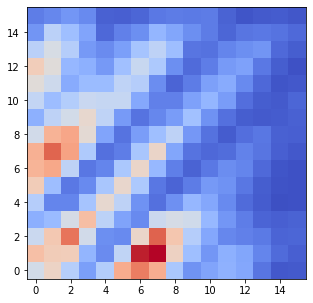

graph of model


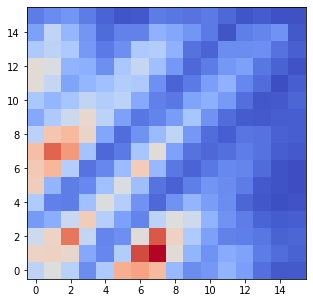

differences


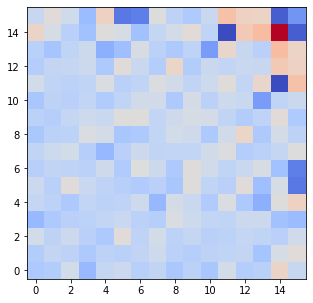

In [21]:
#heat map

plt.rcParams["figure.figsize"] = (5,5)

color_graph=[]

V_max=0 

for i in rules[setting].keys():
    color_graph.append([])
    for j in rules[setting][i]:
        color_graph[-1].append(rules[setting][i][j])
        if V_max<rules[setting][i][j]:
            V_max=rules[setting][i][j]
    
print('graph of data')       
plt.pcolor(range(0,16,1),range(0,16,1),color_graph,shading='auto', cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

color_graph_m=[]

for i in Metr_W["rules_m"][setting].keys():
    color_graph_m.append([])
    for j in Metr_W["rules_m"][setting][i]:
        color_graph_m[-1].append(Metr_W["rules_m"][setting][i][j])
        if V_max<Metr_W["rules_m"][setting][i][j]:
            V_max=Metr_W["rules_m"][setting][i][j]
    

print('graph of model')          
plt.pcolor(range(0,16,1),range(0,16,1),color_graph_m,shading='auto', cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

color_graph_dif=[]


for i in Metr_W["rules_m"][setting].keys():
    color_graph_dif.append([])
    for j in Metr_W["rules_m"][setting][i]:
        if rules[setting][i][j] != 0 :
            diff=Metr_W["rules_m"][setting][i][j]/rules[setting][i][j]
            color_graph_dif[-1].append(diff)
        elif rules[setting][i][j] == 0 :
            diff=0
            color_graph_dif[-1].append(diff)
        
            
print('differences')          
plt.pcolor(range(0,16,1),range(0,16,1),color_graph_dif,shading='auto', cmap='coolwarm')
plt.show()

### 5-3 metrics used for comparison of model and data

In [22]:
#this part returns p_value wilcoxon for comparison age stratified number of contacts 

print('p-value wilcoxon :','%f' % Metr_W['wilx'][1])

print('Pearson Corealtion :',Metr_W['prs_cor'][0],'%f' % Metr_W['prs_cor'][1])

print('mean absoloute error : ', Metr_W['M_Abs'])

print('Manhattan distance :',Metr_W['man_dis'])

print('Euclidean distance :',Metr_W['eu_dis'])

print('Chebyshev distance :',Metr_W['cheb_dis'])

p-value wilcoxon : 0.007667
Pearson Corealtion : 0.9942188519987201 0.000000
mean absoloute error :  0.10350097852046693
Manhattan distance : 4.021983627522644
Euclidean distance : 0.3390876871780819
Chebyshev distance : 0.07902216783216792


### 5-4 time of running the model

In [23]:
print(end-start)

41.04258704185486


### 5-5 evaluation for clustring 

In [24]:
Clus=clustering_rate (results)
print('Num_triangel',Clus[0],'ratio_triangel',Clus[1])

Num_triangel 14278 ratio_triangel 0.35207377817231345


### 5-6 number of contacts in model and expected form data 

In [25]:

table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['source',' number of contacts']])
print(table.draw())

list_contacts={'data':0,'model':0}
#based on rules_sum
for i in rules_sum[setting].keys():

    list_contacts['data']+=rules_sum[setting][i]['contact_total']*age_count[i]
    
#based on contacts
for i in results['graph_array']:
    list_contacts['model']+=len(i[0])


for i in list_contacts.keys():
    
    table.add_rows([[i,'%f' %list_contacts[i]]])
    print(table.draw())


        

source    number of contacts
 data       39803.543960    
model       40554.000000    


### 5-7 mean number of connections for each age in model and data

 age    house hold size data   house hold size model   population
 0_4          5.274035               5.121560            0.0872  
 5_9          6.102179               6.086162            0.0766  
10_14         5.483662               5.740242            0.0743  
15_19         4.267824               4.335664            0.0715  
20_24         2.937386               3.019767            0.086   
25_29         3.006584               3.070107            0.1027  
30_34         3.676568               3.772031            0.1044  
35_39         4.260278               4.412429            0.0885  
40_44         3.963128               4.045171            0.0642  
45_49         3.216837               3.393939            0.0594  
50_54         3.513131               3.506466            0.0464  
55_59         3.385926               3.519451            0.0437  
60_64         3.608533               3.757485            0.0334  
65_69         3.368180               3.347222            0.0216  
70_74     

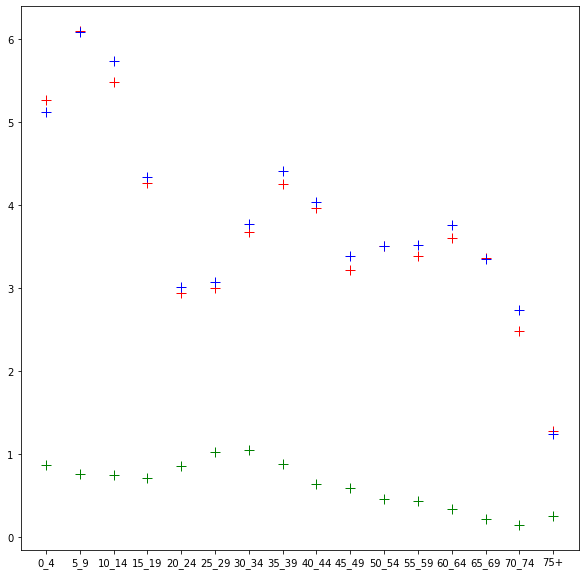

In [26]:
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([[' age ','house hold size data','house hold size model','population']])
print(table.draw())
plt.rcParams["figure.figsize"] = (10,10)

house_hold_size={}
for i in age_count.keys():
    house_hold_size[i]=0
for i in results['graph_array']:
    Age=nodes_dic[i[1]]['age']
    house_hold_size[Age]+=(len(i[0])/age_count[Age])

for i in rules_sum[setting].keys():
    table.add_rows([[i,'%f' %rules_sum[setting][i]['contact_total'],'%f' %house_hold_size[i],age_count[i]/N]])
    print(table.draw())
    plt.plot(i,rules_sum[setting][i]['contact_total'],'r+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,house_hold_size[i],'b+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,age_count[i]/(N/10),'g+',linewidth=2, markersize=10,alpha=1)

### 5-8 progress of metrics while model runs

p-value wilcoxon


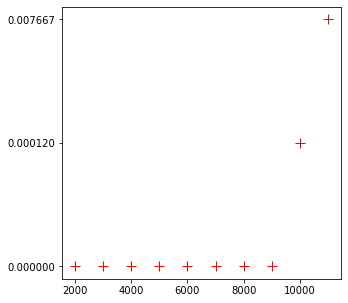

mean absoloute error


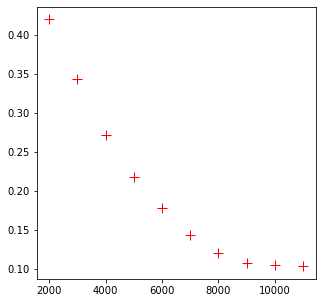

Manhattan distance


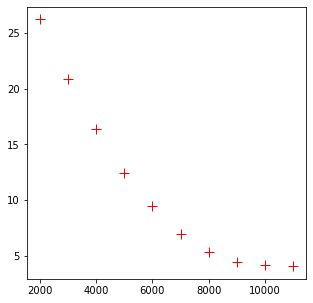

Euclidean distance


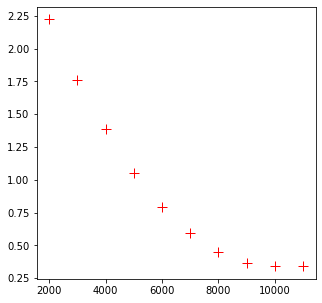

Chebyshev distance


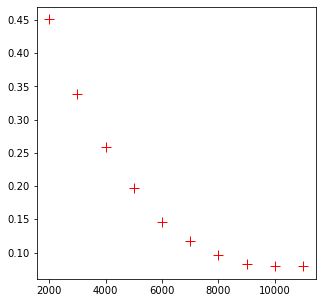

In [27]:
plt.rcParams["figure.figsize"] = (5,5)
samples=results['samples_T']
for metric in samples.keys():
    plt.show()
    print(metric)
    n_sample=sampling_ratio
    for i in samples[metric]:
        n_sample+=sampling_ratio
        plt.plot(n_sample,i,'r+',linewidth=2, markersize=10,alpha=1)
        